## TODO

- I need to correct the token count
- CoT plots:
    - Neue plots wenn nur eine Representation: Am besten alle modelle nebeneinander und dann aber übereinander CoT vs naive? oder difference berechnen und dann ploten +/- 0; Oder einfach wie bei representation und dann Vergleichen 


## Imports

In [1]:
import os
import json
import ast
import numpy as np
import pandas as pd
from IPython.display import clear_output

from itertools import combinations
import matplotlib.pyplot as plt
from adjustText import adjust_text
from tot.methods.arc_utils import load_arc_tasks
import warnings
warnings.filterwarnings("ignore")

In [2]:
SOTA = {
    'arc': {
        'categories_cnt': {'training': 23},
        'success_cnt': 23,
        'categories_rate': {'training': 0.46},
        'success_rate': 0.46
    },
    'arc_h_v': {
        'categories_cnt': {
            'fill_h': 48, 'fill_v': 49, 'move_h': 21, 'move_v': 20, 'pile_h': 42, 'pile_v': 37
        },
        'success_cnt': 217,
        'categories_rate': {
            'fill_h': 0.96, 'fill_v': 0.98, 'move_h': 0.42, 'move_v': 0.4, 'pile_h': 0.84, 'pile_v': 0.74
        },
        'success_rate': 0.7233333333333334
    },
    'arc_1D': {
        'categories_cnt': {
            '1d_denoising_1c': 48, '1d_denoising_mc': 50, '1d_fill': 49, '1d_flip': 50,
            '1d_hollow': 48, '1d_mirror': 13, '1d_move_1p': 50, '1d_move_2p': 50,
            '1d_move_2p_dp': 50, '1d_move_3p': 49, '1d_move_dp': 37, '1d_padded_fill': 44,
            '1d_pcopy_1c': 45, '1d_pcopy_mc': 47, '1d_recolor_cmp': 28, '1d_recolor_cnt': 40,
            '1d_recolor_oe': 13, '1d_scale_dp': 46
        },
        'success_cnt': 757,
        'categories_rate': {
            '1d_denoising_1c': 0.96, '1d_denoising_mc': 1.0, '1d_fill': 0.98, '1d_flip': 1.0,
            '1d_hollow': 0.96, '1d_mirror': 0.26, '1d_move_1p': 1.0, '1d_move_2p': 1.0,
            '1d_move_2p_dp': 1.0, '1d_move_3p': 0.98, '1d_move_dp': 0.74, '1d_padded_fill': 0.88,
            '1d_pcopy_1c': 0.9, '1d_pcopy_mc': 0.94, '1d_recolor_cmp': 0.56, '1d_recolor_cnt': 0.8,
            '1d_recolor_oe': 0.26, '1d_scale_dp': 0.92
        },
        'success_rate': 0.8411111111111111
    }
}



## Helper functions

### Create log summaries

In [3]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Flatten a nested dictionary. Concatenate keys for nested elements.
    """
    items = []
    for k, v in d.items():
        new_key = f'{parent_key}{sep}{k}' if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif k == "new_representation":
            if v is None:
                items.append((new_key, "0 - 9"))
            elif "." in v:
                items.append((new_key, "'.', 'a' - 'i'"))
            elif "a" in v:
                items.append((new_key, "'a' - 'j'"))

            
        else:
            items.append((new_key, v))
    return dict(items)

def get_avg_task_complexity(tasks_jsons, tasks_names, solved_tasks=None):  
    # derive complexity => number of pixels in the test input
    complexity = []
    for task_json in tasks_jsons:
        array = np.array(task_json["test"][0]["input"])
        shape = array.shape
        complexity.append(np.prod(shape))

    df = pd.DataFrame({'task_name': tasks_names, 'complexity': complexity})
    
    if solved_tasks is None:
        return df.complexity.mean()
        
    sum_complexity = 0
    for solved_task in solved_tasks:
        index = np.where(df['task_name'] == solved_task[0])
        sum_complexity += df['complexity'].iloc[index[0][0]]
    if sum_complexity == 0:
        return 0
    return sum_complexity / len(solved_tasks)
    
def read_and_parse_tasks_log(path, save_to_csv=False):
    data = []

    if not os.path.isdir(path):
        print(f"The provided path {path} is not a directory.")
        return pd.DataFrame()
    
    # derive task
    task = path.split("/")[-1]
    # get all tasks
    data_dir = os.path.join("tree-of-thought-llm/src/tot/data", task)
    tasks_jsons, tasks_names, _ = load_arc_tasks(data_dir, task)

    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            log_file = os.path.join(item_path, 'all_tasks_log.json')
            if os.path.isfile(log_file):
                try:
                    with open(log_file, 'r') as file:
                        log_data = json.load(file)[0]  # Read only the first item
                        flattened_data = flatten_dict(log_data)
                        solved_tasks = flattened_data["solved_tasks"]
                        if len(solved_tasks) >= 3:
                            avg_complexity = get_avg_task_complexity(tasks_jsons, tasks_names, flattened_data["solved_tasks"])
                        else:
                            avg_complexity = 0 
                        flattened_data["avg_complexity"] = avg_complexity
                        data.append(flattened_data)
                except Exception as e:
                    print(f"Error reading {log_file}: {e}")
    df = pd.DataFrame(data)
    if save_to_csv:
        df.to_csv(path+"/summary.csv", index=False)
        print("saved to "+path+"/summary.csv")
    return df


In [6]:
path = "results/baseline_cot/arc_1D"
data = read_and_parse_tasks_log(path, save_to_csv=True)
#display(data)

Total number of tasks: 901
saved to results/baseline_cot/arc_1D/summary.csv


### Plotting functions

In [4]:
def plot_model_performance_across_runs(dataframe, exp_column, score_column, task="", SOTA=None):
    # Filter the relevant columns
    df_filtered = dataframe[['model', exp_column, score_column]]

    # Convert Score to numeric values if they are in percentage format
    if df_filtered[score_column].dtype == object:
        df_filtered[score_column] = df_filtered[score_column].str.rstrip('%').astype('float') / 100.0

    # Step 1 & 2: Group by 'Model' and find the maximum 'Success' value for each group
    group_max = df_filtered.groupby('model')[score_column].max()

    # Step 3: Sort the groups by maximum 'Success' value
    sorted_groups = group_max.sort_values(ascending=False).index.tolist()

    # Step 4 & 5: Sort within each group by 'Representation' and concatenate
    sorted_df = pd.concat([df_filtered[df_filtered['model'] == group].sort_values(by=exp_column) for group in sorted_groups])

    sorted_df.reset_index(drop=True, inplace=True)

    # Set the style for the plots
    plt.style.use('seaborn-darkgrid')

    # add multiplication if not in percentage format
    if score_column == "avg_complexity":
        m = 100
    else: 
        m = 1
        
    # Create a line plot for each model
    tmp_last_y_left = tmp_last_y_right = -999
    for model in sorted_groups:
        model_data = sorted_df[sorted_df['model'] == model]
        line = plt.plot(model_data[exp_column], model_data[score_column], marker='o', label=model.split("/")[-1])
        line_color = line[0].get_color()  # Get the color of the line
        
        # Find the highest score for the model
        max_score = model_data[score_column].max()
        max_score_data = model_data[model_data[score_column] == max_score]
        
        if max_score == 0:
            continue

        # Highlight the highest score for the model
        plt.scatter(max_score_data[exp_column], max_score_data[score_column], color=line_color, s=60, edgecolor='black', zorder=5)
        
        # Check the position of the highest score and adjust the annotation accordingly
        for _, row in max_score_data.iterrows():
            data_point_y = row[score_column]
            if row[exp_column] == model_data[exp_column].iloc[0]:  # If highest score is in the first run
                if data_point_y - tmp_last_y_left < 0.02*m and data_point_y - tmp_last_y_left > -0.02*m:
                    y_annotation_lift_l += -4
                else:
                    y_annotation_lift_l = 0
                plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
                            textcoords="offset points", xytext=(-35,2+y_annotation_lift_l), ha='left')
                tmp_last_y_left = data_point_y
            elif row[exp_column] == model_data[exp_column].iloc[-1]:  # If highest score is in the last run
                if data_point_y - tmp_last_y_right < 0.02*m and data_point_y - tmp_last_y_right > -0.02*m:
                    y_annotation_lift_r += -4
                else:
                    y_annotation_lift_r = 0
                plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
                            textcoords="offset points", xytext=(35,2+y_annotation_lift_r), ha='right')
                tmp_last_y_right = data_point_y
            else:  # For all other cases, put the annotation above the point
                plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
                            textcoords="offset points", xytext=(0,7), ha='center')

    # add SOTA
    if SOTA is not None:
        success_rate = SOTA[task]["success_rate"]
        plt.axhline(y=success_rate, color='r', linestyle=':', label='SOTA')
     
    # add avg complexity of whole task
    if score_column == "avg_complexity":
        # get all tasks
        data_dir = os.path.join("tree-of-thought-llm/src/tot/data", task)
        tasks_jsons, tasks_names, _ = load_arc_tasks(data_dir, task)
        avg_complexity = get_avg_task_complexity(tasks_jsons, tasks_names)
        plt.axhline(y=avg_complexity, color='r', linestyle=':', label='Average over all tasks')
        
    # Adjust margins here by setting x-axis limits
    # Get current axis
    ax = plt.gca()
    # Retrieve the current limits
    xmin, xmax = ax.get_xlim()
    # Set new limits with some padding
    ax.set_xlim(xmin - 0.5, xmax + 0.5)
        
    # Adding legends, labels and title
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel(exp_column)
    plt.ylabel(score_column)
    if task == "arc_1D":
        task_name = "1D ARC - "
    elif task == "arc_h_v":
        task_name = "ARC horizontal vs. vertical - " 
    elif task == "arc":
        task_name = "50 ARC Tasks - "
    else:
        task_name = ""
    
    if score_column == "avg_complexity":
        plt.title(task_name + 'Average Complexity of Models Across different Experiments')
    elif score_column == "success_rate":
        plt.title(task_name + 'Success rate of Models Across different Experiments')
    else:
        plt.title(task_name + 'Performance of Models Across different Experiments')

    # Show the plot
    plt.show()


In [ ]:
# remove substring "cat_success_rate_" from elements in the list
data["model"] = data["model"].str.replace("cat_success_rate_", "")

In [5]:
def plot_grouped_bar_chart(dataframe, top_n_models=3, SOTA=None):
    # filter on top n models
    dataframe = dataframe.sort_values(by='success_rate', ascending=False)
    
    
    # Filter columns that start with 'cat_success_'
    success_columns = [col for col in dataframe.columns if col.startswith('cat_success_rate_')]
    
    # filter dataframe
    dataframe = dataframe[['model'] + success_columns]
    dataframe = dataframe[:top_n_models]
    
    
    # add SOTA
    if SOTA is not None:
        modified_keys_dict = {'cat_success_rate_' + key: value for key, value in SOTA["categories_rate"].items()}
        new_row = pd.DataFrame([modified_keys_dict])
        new_row['model'] = 'SOTA'
        dataframe = pd.concat([dataframe, new_row], ignore_index=True)
    
    models = dataframe['model'].unique()
    
    # Number of groups
    n_groups = len(success_columns)
    
    # Create figure and axis
    fig, ax = plt.subplots()
    plt.axhline(y=1, color='r', linestyle=':', label='100%')
    # Set the positions and width for the bars
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    
    # Generate a bar for each model in each group
    for i, model in enumerate(models):
        # Select data for the model
        model_data = dataframe[dataframe['model'] == model][success_columns].iloc[0]
        
        # Position of the model's bar in each group
        pos = [p + bar_width * i for p in index]
        
        # Plotting
        plt.bar(pos, model_data, bar_width, alpha=opacity, label=model)
    
    # Adding features to the plot
    plt.xlabel('Categories')
    plt.ylabel('Success Rate')
    plt.title('Success rate by model and category')
    plt.xticks(index + bar_width / 2, [s.replace("cat_success_rate_", "") for s in success_columns], rotation=45, ha="right")
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [7]:
# For Venn diagramm

def get_overlapping_tasks(data):

    data["solved_tasks"] = [[task[0] for task in tasks] for tasks in data["solved_tasks"]]

    # Create a dictionary to store solved tasks for each model
    model_tasks = {row['model']: set(row['solved_tasks']) for _, row in data.iterrows()}

    result = {}

    # Create combinations of models and find the overlapping tasks for triples
    combinations_triples = list(combinations(data['model'], 3))

    for combination in combinations_triples:
        model1, model2, model3 = combination
        overlapping_tasks = model_tasks[model1].intersection(model_tasks[model2], model_tasks[model3])
        result[f'{model1}-{model2}-{model3}'] = list(overlapping_tasks)

        # Remove overlapping tasks from individual models
        for model in combination:
            model_tasks[model] -= overlapping_tasks

    # Create combinations of models and find the overlapping tasks for pairs
    combinations_pairs = list(combinations(data['model'], 2))

    for combination in combinations_pairs:
        model1, model2 = combination
        overlapping_tasks = model_tasks[model1].intersection(model_tasks[model2])
        result[f'{model1}-{model2}'] = list(overlapping_tasks)

        # Remove overlapping tasks from individual models
        for model in combination:
            model_tasks[model] -= overlapping_tasks

    # For individual models
    for model, tasks in model_tasks.items():
        result[model] = list(tasks)

    return result



In [158]:
# Group the DataFrame by the "Model" column and find the index of the maximum "Success_rate" within each group
idx = data.groupby('model')['success_rate'].idxmax()
# Extract the rows corresponding to the best "Success_rate" for each model
best_rows = data.loc[idx]
# Sort the best_rows DataFrame by "Success_rate" in descending order
best_rows_sorted = best_rows.sort_values(by='success_rate', ascending=False)
# Select the top 4 rows (i.e., the 4 best models)
top_3_models = best_rows_sorted.head(3)
top_3_models["solved_tasks"]
# Call the function with your DataFrame
result = get_overlapping_tasks(top_3_models)

#Print the result
for model, tasks in result.items():
    print(f'{model}: {len(tasks)}')

gpt-4-1106-preview-gpt-3.5-turbo-1106-mistralai/Mistral-7B-v0.1: 97
gpt-4-1106-preview-gpt-3.5-turbo-1106: 89
gpt-4-1106-preview-mistralai/Mistral-7B-v0.1: 68
gpt-3.5-turbo-1106-mistralai/Mistral-7B-v0.1: 21
gpt-4-1106-preview: 202
gpt-3.5-turbo-1106: 40
mistralai/Mistral-7B-v0.1: 35


In [161]:
top_3_models["success_cnt"]

35    456
2     247
28    221
Name: success_cnt, dtype: int64

### Task analysis

In [9]:
def analyze_random_tasks(data, task, exp, n_models, n_tasks, only_unsolved=False, only_solved=False, starting_index=0, only_save_as_txt=False):
    # random seed
    np.random.seed(42)
    # get all tasks
    data_dir = os.path.join("tree-of-thought-llm/src/tot/data", task)
    _, tasks_names, _ = load_arc_tasks(data_dir, task)
    # get experiment data of top n models
    top_n_runs = data.sort_values(by='success_rate', ascending=False)[:n_models]
    # iterate over the top n runs
    selected_tasks = {}
    for index, row in top_n_runs.iterrows():
        #print(row["solved_tasks"])
        solved_tasks = ast.literal_eval(row["solved_tasks"])
        solved_tasks = [t[0] for t in solved_tasks]
        unsolved_tasks = [t for t in tasks_names if t not in solved_tasks]
        if only_unsolved:
            tasks = unsolved_tasks
        elif only_solved:
            tasks = solved_tasks
        else:
            tasks = tasks_names
        np.random.shuffle(tasks)
        if n_tasks > len(tasks):
            n_tasks = len(tasks)
        if exp == "baseline_cot":
            run_postfix = "naive_cot"
        selected_tasks[f'{row["model"].split("/")[-1]}_{run_postfix}_{row["date"]}'] = np.random.choice(tasks, n_tasks, replace=False)

    txt = ""
    for run, tasks in selected_tasks.items():
        results_path = f"results/{exp}/{task}/{run}/tasks/"
        
        run_txt = '''
############################################################################################################
New Run: {}
############################################################################################################
'''.format(run)
        print(run_txt)
        if only_save_as_txt:
            txt += run_txt+"\n"
        user_input = input("Do you want to continue? (y/n) Or skip to next model? (skip)")
        if user_input == "skip":
            continue
        elif user_input != "y":
            print("Aborted")
            break
        
        for i, t in enumerate(tasks):
            if i < starting_index:
                continue
            task_path = os.path.join(results_path, t[:-5]+"_LLM_answer.txt")
            with open(task_path) as f:
                content = f.read()
            if only_save_as_txt:
                txt += f'''\n############################################################################################################\nTask: {t}\n\n{content}\n\n'''
            else:
                print(t)
                print(content)
                user_input = input("Do you want to continue? (y/n) Or show again? (again)")
                while user_input == "again":
                    clear_output() 
                    print(t)
                    print(content)
                    user_input = input("Do you want to continue? (y/n) Or show again? (again)")
                if user_input != "y":
                    clear_output() 
                    print("Aborted")
                    break
                clear_output()
    if only_save_as_txt:
        with open(f"results/baseline_cot/{task}/manual_task_analysis_raw_outputs.txt", "w") as text_file:
            text_file.write(txt)
        print(f"saved to results/{exp}/{task}/manual_task_analysis_raw_outputs.txt")
        
            
def get_task_analysis_kpi(path):
    # Open the Excel file and get sheet names
    xls = pd.ExcelFile(path)
    sheet_names = xls.sheet_names
    sheet_names.remove("template")
    sheet_names.remove("Legend")
    
    kpis = {}
    
    for sheet in sheet_names:
        # Load the sheet and remove rows with NaN in the "task_name" column
        df = pd.read_excel(path, sheet_name=sheet)
        df = df.dropna(subset=['task_name'])
        n_tasks = len(df)
        
        # Calculate fraction of tasks where the description of differences between input and output is correct and complete
        description_correct_and_complete_fraction = df['description_of_difference_correct_and_complete'].sum() / n_tasks

        # Calculate fraction of tasks where the description of differences between input and output is correct but incomplete
        description_correct_but_missing_relevant_details_fraction = df['description_correct_but_missing_relevant_details'].sum() / n_tasks

        # calculate fraction of examples where the description error is due to bad object detection
        description_error_bc_bad_object_detection_fraction = df['description_error_bc_bad_object_detection'].sum() / (df['description_of_difference_correct_and_complete'] == 0).sum() 

        # Calculate fraction of correct test case descriptions
        test_case_description_correct_fraction = df['test_description_correct'].sum() / n_tasks
        
        # calculate fraction of examples where the test case description error is due to bad object detection
        test_case_description_error_bc_bad_object_detection_fraction = df['test_objects_correct'].sum() / df['test_object_described_w_all_details'].sum() 
        
        # Calculate fraction of correct chain
        correct_chain_fraction = df[(df['description_of_difference_correct_and'] == 1) & 
                                    (df['pattern_correct'] == 1) & 
                                    (df['conditions_correct'] == 1) & 
                                    (df['instructions_correct'] == 1) & 
                                    (df['test_transformation_correct'] == 1)].shape[0] / n_tasks
        
        # Calculate fraction of correct pattern
        correct_pattern_fraction = df[(df['pattern_correct'] == 1) & 
                                      (df['conditions_correct'] == 1)].shape[0] / n_tasks
        
        # Calculate fraction of correct instructions
        correct_instructions_fraction = df['instructions_correct'].sum() / n_tasks
        
        # Calculate fraction of correct transformations
        correct_transformations_fraction = df['test_transformation_correct'].sum() / n_tasks
        
        # Calculate fraction of instructions that are correct with respect to wrong pattern
        instructions_fit_wrong_pattern_fraction = df[(df['pattern_correct'] == 0) & 
                                                     (df['wrong_instructions_but_fit_to_pattern'] == 1)].shape[0] / n_tasks
        
        # calculate fraction of transformations that are correct with respect to wrong pattern
        transformations_fit_wrong_pattern_fraction = df[(df['pattern_correct'] == 0) & 
                                                       (df['wrong_test_transformation_but_fit_to_pattern'] == 1)].shape[0] / n_tasks
        
        # calculate fraction of wrong pattern but identified key concept correctly
        wrong_pattern_but_key_concept_fraction = df[(df['pattern_correct'] == 0) & 
                                                    (df['key_concept_correct'] == 1)].shape[0] / n_tasks
        
        # calculate fraction of tasks where numbers were interpreted arithmetically
        arithmetic_interpretation_fraction = df['numbers_interpreted_arithmetical'].sum() / n_tasks
        
        # Store KPIs for the current sheet
        kpis[sheet] = {
            "n_tasks": n_tasks,
            "description_correct_and_complete_fraction": description_correct_and_complete_fraction,
            "description_correct_but_missing_relevant_details_fraction": description_correct_but_missing_relevant_details_fraction,
            "description_error_bc_bad_object_detection_fraction": description_error_bc_bad_object_detection_fraction,
            "test_case_description_correct_fraction": test_case_description_correct_fraction,
            "test_case_description_error_bc_bad_object_detection_fraction": test_case_description_error_bc_bad_object_detection_fraction,
            "correct_chain_fraction": correct_chain_fraction,
            "correct_pattern_fraction": correct_pattern_fraction,
            "correct_instructions_fraction": correct_instructions_fraction,
            "correct_transformations_fraction": correct_transformations_fraction,
            "instructions_fit_wrong_pattern_fraction": instructions_fit_wrong_pattern_fraction,
            "transformations_fit_wrong_pattern_fraction": transformations_fit_wrong_pattern_fraction,
            "wrong_pattern_but_key_concept_fraction": wrong_pattern_but_key_concept_fraction,
            "arithmetic_interpretation_fraction": arithmetic_interpretation_fraction
        }
        
    return kpis


# Experiments

## Baseline - Naive

### 1D ARC

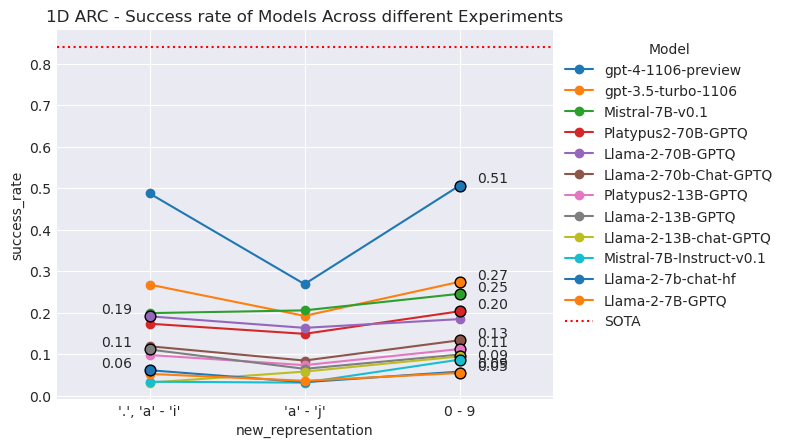

In [10]:
df = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_1D", SOTA=SOTA)

Total number of tasks: 901


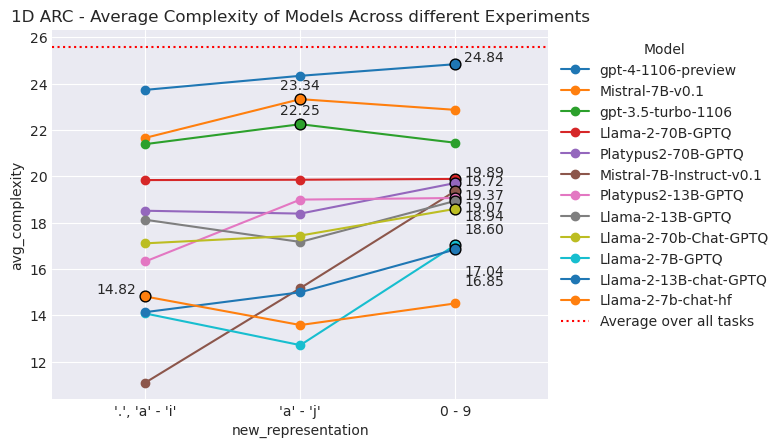

In [11]:
df = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc_1D")

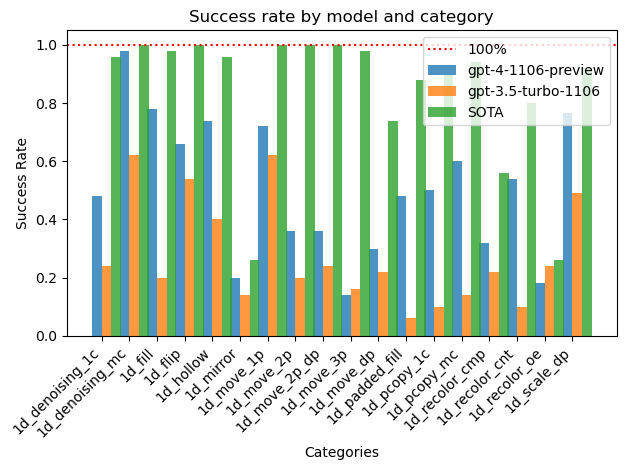

In [25]:
df = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=2, sota=SOTA["arc_1D"])


### ARC H vs V

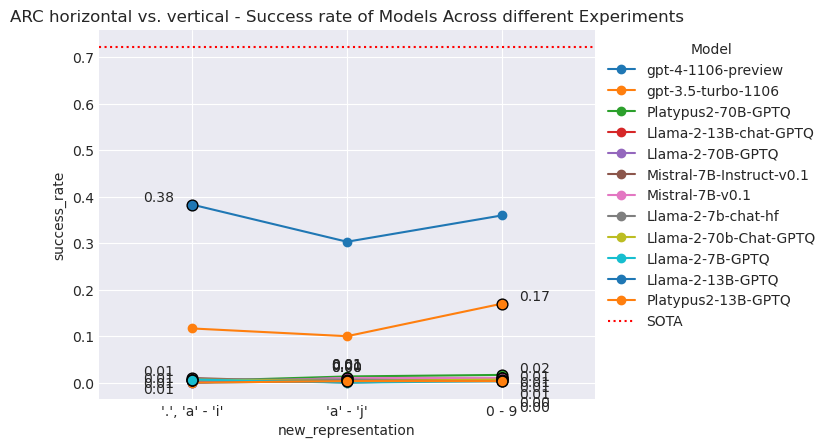

In [13]:
df = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_h_v", SOTA=SOTA)

Total number of tasks: 300


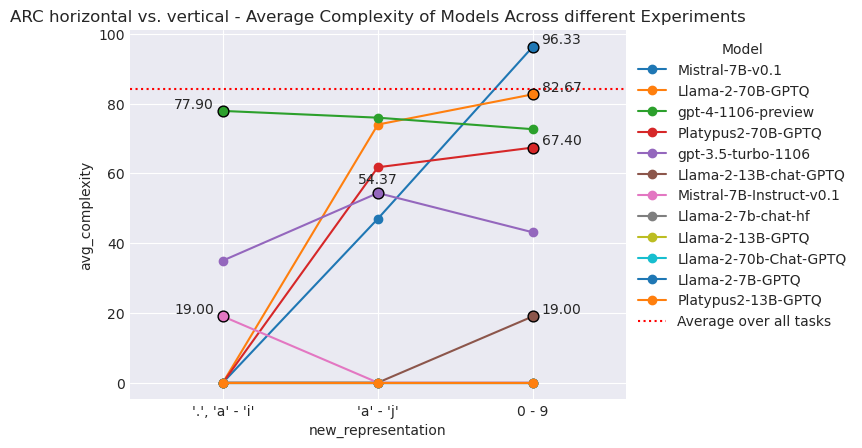

In [14]:
df = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc_h_v")

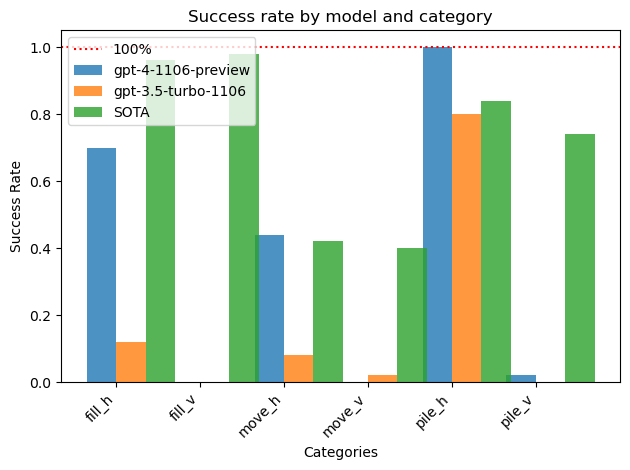

In [32]:
df = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=2, SOTA=SOTA["arc_h_v"])

### ARC original

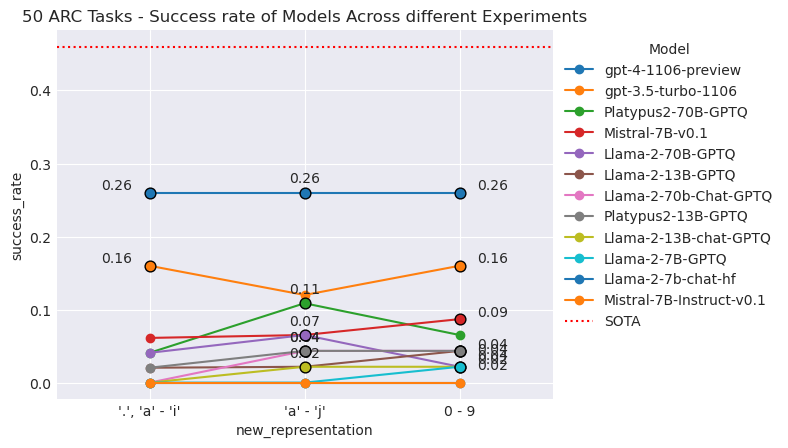

In [16]:
df = pd.read_csv("results/baseline_naive/arc/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc", SOTA=SOTA)

Total number of tasks: 50


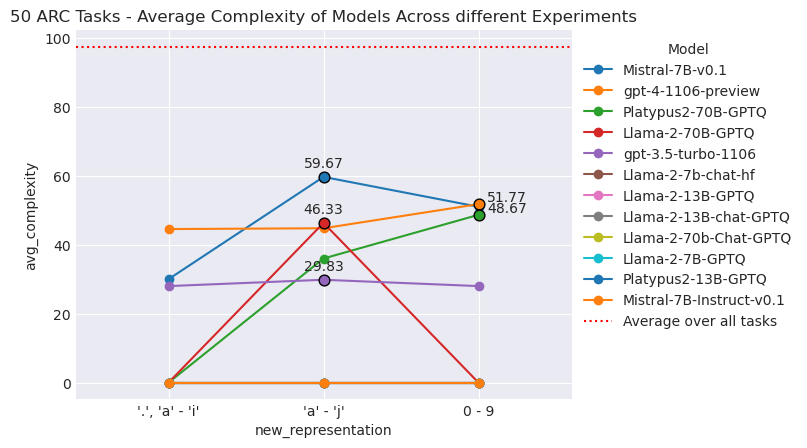

In [17]:
df = pd.read_csv("results/baseline_naive/arc/summary.csv")
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc")

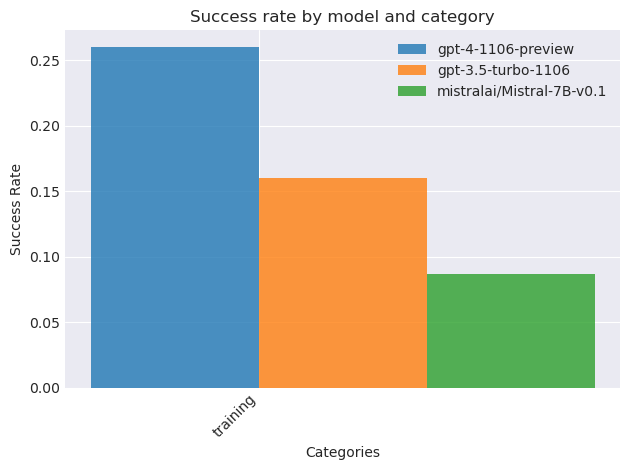

In [18]:
df = pd.read_csv("results/baseline_naive/arc/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=3)

## Baseline - CoT

### 1D ARC

#### Plots

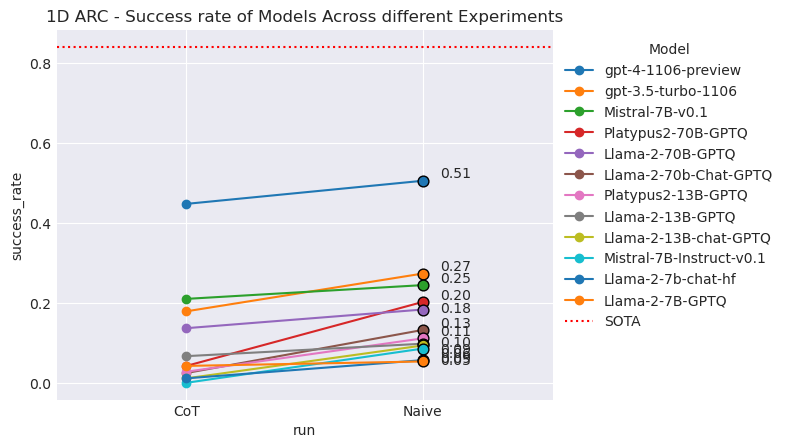

In [20]:
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", SOTA=SOTA)

Total number of tasks: 901


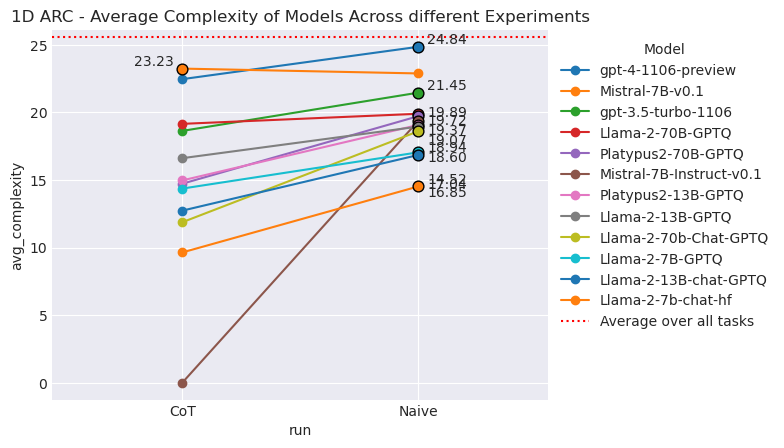

In [21]:
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "avg_complexity", task="arc_1D")


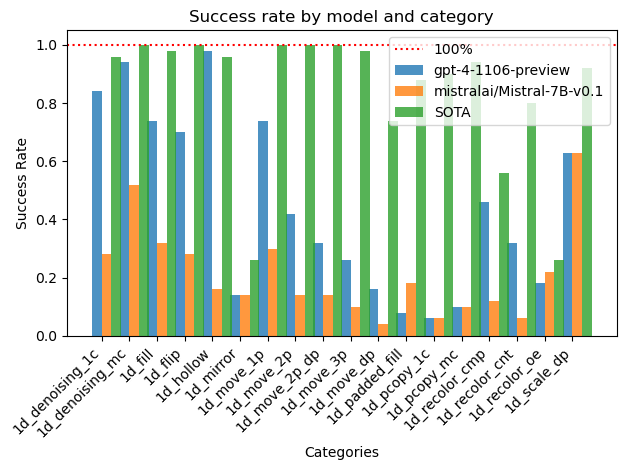

In [26]:
df = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
plot_grouped_bar_chart(df, top_n_models=2, sota=SOTA["arc_1D"])

#### Chain of thought analysis

In [10]:
# manually analyze # TODO: change data in tot src
df = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
analyze_random_tasks(df, "arc_1D", "baseline_cot", n_models=3, n_tasks=20, only_unsolved=True, only_solved=False, starting_index=0, only_save_as_txt=True)


Total number of tasks: 901

              ############################################################################################################
              New Run: gpt-4-1106-preview_naive_cot_2024-02-08_09-42-53
              ############################################################################################################
            

              ############################################################################################################
              New Run: gpt-3.5-turbo-1106_naive_cot_2024-02-07_14-51-44
              ############################################################################################################
            

              ############################################################################################################
              New Run: Llama-2-70B-GPTQ_naive_cot_2024-02-07_09-36-06
              #####################################################################################################

In [22]:
path="results/baseline_cot/arc_1D/manual_task_analysis.xlsx"
get_task_analysis_kpi(path)

{'naive_cot_gpt4': {'n_tasks': 20,
  'description_correct_fraction': 0.25,
  'test_description_correct_fraction': 1.0,
  'correct_chain_fraction': 0.0,
  'correct_pattern_fraction': 0.0,
  'correct_instructions_fraction': 0.0,
  'correct_transformations_fraction': 0.0,
  'instructions_fit_wrong_pattern_fraction': 0.95,
  'transformations_fit_wrong_pattern_fraction': 0.7,
  'wrong_pattern_but_key_concept_fraction': 0.55,
  'arithmetic_interpretation_fraction': 0.15},
 'naive_cot_gpt3': {'n_tasks': 20,
  'description_correct_fraction': 0.1,
  'test_description_correct_fraction': 0.45,
  'correct_chain_fraction': 0.0,
  'correct_pattern_fraction': 0.0,
  'correct_instructions_fraction': 0.0,
  'correct_transformations_fraction': 0.05,
  'instructions_fit_wrong_pattern_fraction': 0.9,
  'transformations_fit_wrong_pattern_fraction': 0.5,
  'wrong_pattern_but_key_concept_fraction': 0.45,
  'arithmetic_interpretation_fraction': 0.05}}

### ARC H vs V

#### Plots

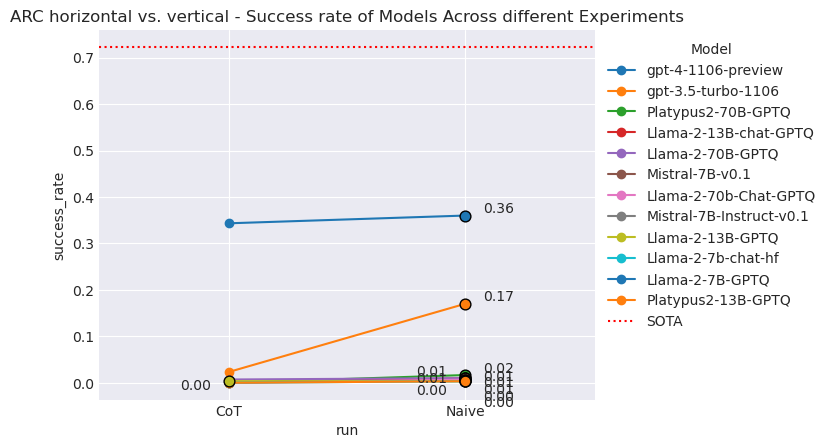

In [23]:
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", SOTA=SOTA)

Total number of tasks: 300


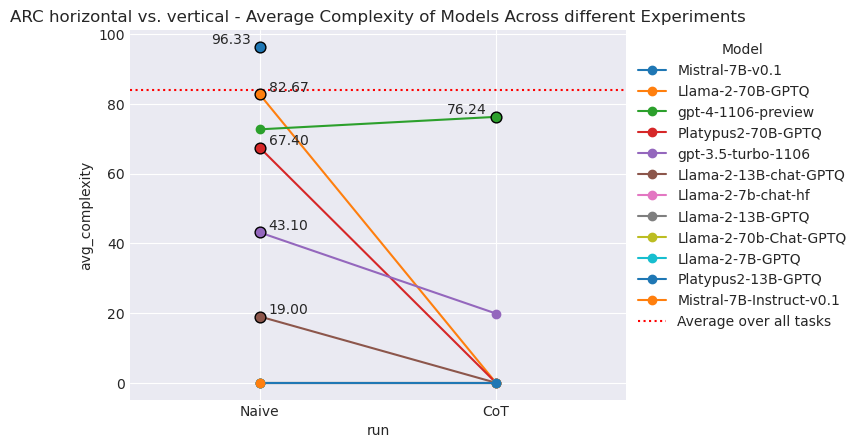

In [24]:
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "avg_complexity", task="arc_h_v")

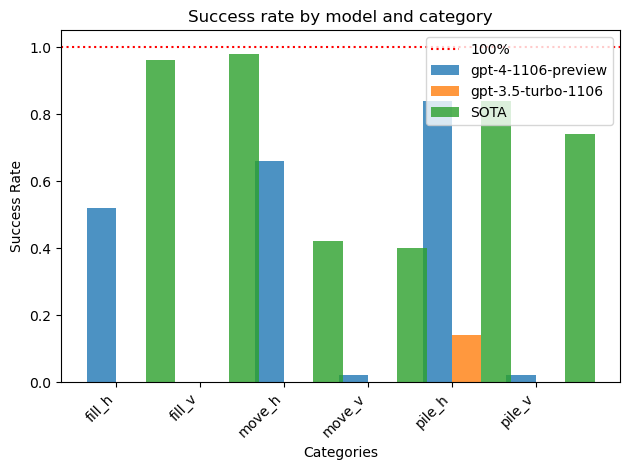

In [33]:
df = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=2, SOTA=SOTA["arc_h_v"])

#### Chain of thought analysis

### ARC original

#### Plots

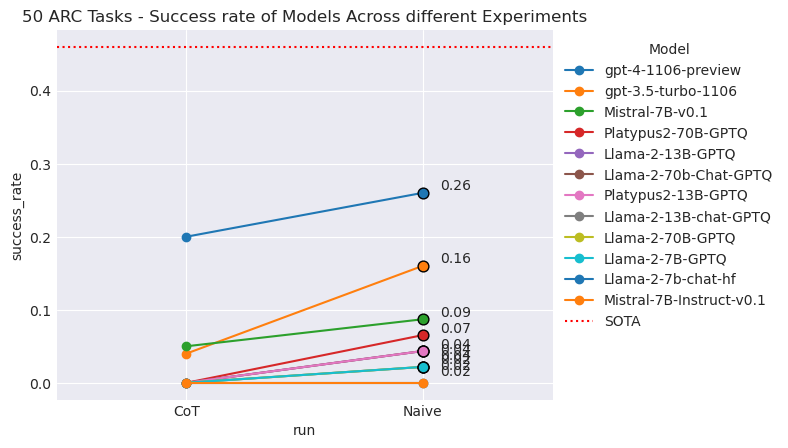

In [25]:
df_naive = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc", SOTA=SOTA)

Total number of tasks: 50


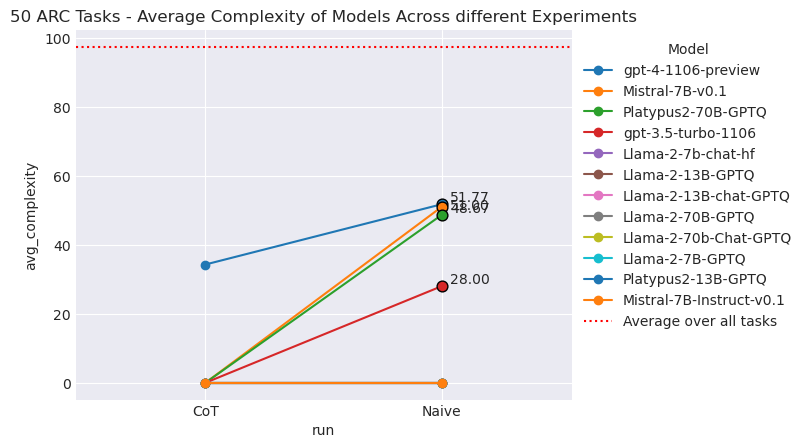

In [26]:
df_naive = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "avg_complexity", task="arc")

#### Chain of thought analysis

In [26]:
# manually analyze
df = pd.read_csv("results/baseline_cot/arc/summary.csv")
analyze_random_tasks(df, "arc", "naive_cot", n_models=3, n_tasks=20, only_unsolved=False, only_solved=True, starting_index=0)


Total number of tasks: 50
{'gpt-4-1106-preview_naive_cot_2024-02-09_09-19-25': array(['d037b0a7.json', '6150a2bd.json', 'a79310a0.json', '74dd1130.json',
       '25ff71a9.json', 'ce22a75a.json', 'aabf363d.json', 'c8f0f002.json',
       'dc433765.json', 'b1948b0a.json'], dtype='<U13'), 'gpt-3.5-turbo-1106_naive_cot_2024-02-08_09-06-52': array(['c8f0f002.json', 'b1948b0a.json'], dtype='<U13')}

              ############################################################################################################
              New Run: gpt-4-1106-preview_naive_cot_2024-02-09_09-19-25
              ############################################################################################################
            


Aborted


## Tree of Thought